In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *
import matplotlib.patheffects as PathEffects
import matplotlib.patheffects as PathEffects
cwd=os.getcwd()
sys.path.append("../python scripts/")


from nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
from cut_mdhisto_powder import *
from mdfactorization import *
from trapzerr import *
from mask_minQ import *
from maskQEbox import *
#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.close('all')
%matplotlib inline

# This notebook performs the factorization analysis on all three measurements as defined in the main text. It also makes plots of the scattering for the text.

The order is the following :

1. First plot showing SEQUOIA magnetic scattering at 4 K and 100 K with accompanying cuts of raw data
2. Second plot with MACS Data
3. Third plot with MACS, SEQUOIA factorizations
4. Final plot showing polarized scattering results. 

In [18]:
#Load the files correctly, sort into a dictionary.

mds = {}
keys= ['seq_mag','seq_100K','macs_5mag','macs_3p7mag','hys_mag','hys_SF','seq_mag_60meV',\
       'macs_2K_5meV','macs_55K_5meV','macs_2K_3p7meV','macs_55K_3p7meV','hys_SI','hys_NSF']
fdict = {keys[0]:'../MDHisto_files/30_4K_SEQ_mag.nxs',\
        keys[1]:'../MDHisto_files/30_100K_SEQ_mag.nxs',\
        keys[2]:'../MDHisto_files/HLIO_MACS_5p0_mag.nxs',\
        keys[3]:'../MDHisto_files/HLIO_MACS_3p7_mag.nxs',\
        keys[4]:'../MDHisto_files/HLIO_mag_avg.nxspe',\
        keys[5]:'../MDHisto_files/HLIO_tot_SF.nxspe',\
        keys[6]:'../MDHisto_files/60_4K_SEQ_mag.nxs',\
        keys[7]:'../MDHisto_files/macs_5p0_2K.nxs',\
        keys[8]:'../MDHisto_files/macs_5p0_55K.nxs',\
        keys[9]:'../MDHisto_files/macs_3p7_2K.nxs',\
        keys[10]:'../MDHisto_files/macs_3p7_55K.nxs',\
        keys[11]:'../MDHisto_files/HLIO_SI.nxspe',\
        keys[12]:'../MDHisto_files/HLIO_tot_NSF.nxspe'}

qslice_mag = GenQslice(0,3,15)
eslice_mag = GenEslice(0,20,10)
qslice_hys = GenQslice(0,3,60)
eslice_hys = GenEslice(0,20,60)
Qslices={keys[4]:qslice_mag,keys[5]:qslice_hys,keys[11]:qslice_hys,keys[12]:qslice_hys}
Eslices={keys[4]:eslice_mag,keys[5]:eslice_hys,keys[11]:eslice_hys,keys[12]:eslice_hys}
for key in keys:
    if 'nxspe' not in fdict[key]:
        ws = LoadMD(fdict[key])
        #For SEQ measurements, mask low angles.
        if 'SEQ' in fdict[key]:
            fname = fdict[key]
            Ei = float(fname.split('/')[-1].split('_')[0])
            ws = mask_minQ_fixedEi_MD(ws,twoThetaMin=4.5,Ei=Ei)
        if 'macs' in fdict[key]:
            fname = fdict[key]
            Ef = float(fname.split('/')[-1].split('_')[1].replace('p','.'))
            ws = mask_minQ_fixedEf_MD(ws,twoThetaMin=12.0,Ef=Ef)
        outws=CloneWorkspace(ws,OutputWorkspace=key)
        mds[key]=outws
    else:
        #HYS data needs to be binned. 
        md = NxspeToMDHisto(fdict[key],Qslices[key],Eslices[key],numEvNorm=False)
        hysscale=2.0e5#1.2e5
        md*=hysscale
        outws=CloneWorkspace(md,OutputWorkspace=key)
        mds[key]=outws        

constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


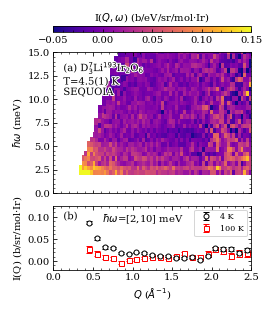

In [19]:
#Begin with a figure showing the SEQUOIA scattering and accompanying cuts

fig=plt.figure(constrained_layout=True,figsize=(3.54,4))

gs = matplotlib.gridspec.GridSpec(3,1,figure=fig)
ax_slice = fig.add_subplot(gs[0:2],projection='mantid')
ax_qcut = fig.add_subplot(gs[2])
#perform the appropriate masking of the elastic line.

ws_masked_60= mask_QE_box_MD(mtd['seq_mag_60meV'],[0,5],[0,3])
ws_masked_60 = CloneWorkspace(ws_masked_60,OutputWorkspace='seq_mag_60meV_plot')
ws_masked_60 = SmoothMD(ws_masked_60,'Hat',WidthVector=1)

ws_masked= mask_QE_box_MD(mtd['seq_mag'],[0,5],[0,1.8])
ws_masked = CloneWorkspace(ws_masked,OutputWorkspace='seq_mag_plot')
ws_masked = SmoothMD(ws_masked,'Hat',WidthVector=1)

cmap='plasma'
vmin=-0.05
vmax=0.15
mesh=ax_slice.pcolormesh(ws_masked_60,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True,zorder=1)

mesh=ax_slice.pcolormesh(ws_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True,zorder=2)
ax_slice.set_ylim(0,15)
ax_slice.set_xlabel('')
ax_slice.set_ylabel('$\hbar\omega$ (meV)')
ax_slice.set_xticklabels([])

txta = ax_slice.text(0.05,0.95,'(a) D$_3^7$Li$^{193}$Ir$_2$O$_6$\nT=4.5(1) K\nSEQUOIA',transform=ax_slice.transAxes,\
                    horizontalalignment='left',verticalalignment='top')
txta.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar
l,b,w,h=ax_slice.get_position().bounds
cax = fig.add_axes([l,b+h+0.07,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

#Plot cuts of both the 100 K and 4 K magnetic scattering. 
qbins=[0,3,0.1]
ebins=[2,10]
q4,i4,err4 = cut_MDHisto_powder(mtd['seq_mag'],'|Q|',qbins,ebins)
q100,i100,err100=cut_MDHisto_powder(mtd['seq_100K'],'|Q|',qbins,ebins)
ax_qcut.errorbar(q4,i4,err4,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3,label='4 K',\
                zorder=10)
ax_qcut.errorbar(q100,i100,err100,color='r',marker='s',mfc='w',mec='r',ls=' ',capsize=3,\
                 zorder=5,label='100 K')
ax_qcut.legend(fontsize=8,loc=1,ncol=1)

txtb = ax_qcut.text(0.05,0.90,'(b)',transform=ax_qcut.transAxes,\
                    horizontalalignment='left',verticalalignment='top',)
txtb.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

txtb2 = ax_qcut.text(0.45,0.90, '$\hbar\omega$=[2,10] meV',transform=ax_qcut.transAxes,horizontalalignment='center',\
                    verticalalignment='top')

#Make x limits consistent
ax_slice.set_xlim(0,2.5)
ax_qcut.set_xlim(0,2.5)
ax_qcut.set_ylim(-0.02,0.125)

ax_qcut.set_xlabel('$Q$ ($\AA^{-1}$)')
ax_qcut.set_ylabel('I(Q) (b/sr/mol$\cdot$Ir)')

fig.savefig('DLIO_SEQ_scattering.pdf',bbox_inches='tight',dpi=400)

## The factorization of the above scattering is handled in the script mdfactorization.py

Be wary that the calculation of uncertainties takes a significant amount of time (~10 min on test desktop). To skip that calculation, set fast_mode=True for a 30% error bar. Feel free to load the pre-calculated factorization.

The plot for the factorization will be 

In [20]:
seq_factor_fname='SEQ_fact.npy'
qseq,sqseq,sqerrseq,eseq,geseq,geerrseq=MDfactorization(mtd['seq_mag'],mag_ion='Ir4',\
                                     q_lim=[0.35,2.0],e_lim=[2,10.0],Ei=60.0,\
                                     twoThetaMin=4.0,plot_result=False,method='powell',fname=seq_factor_fname,\
                                     overwrite_prev=False,allow_neg_E=False,g_factor=2.0,fast_mode=False)

Mu_eff from factorization=1.77(0.321) muB


<ErrorbarContainer object of 3 artists>

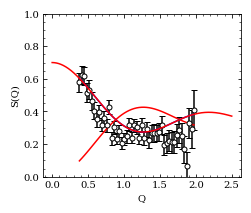

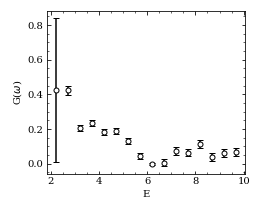

In [21]:
#Quick plot offactorization below.
norm_err = 0.3
frac_err = norm_err#*sqseq/sqerrseq
#Also check the measured moment. 
mu_eff = np.sqrt(3.0*(2.0**2)*np.trapz(sqseq*(qseq**2),x=qseq)/np.trapz(qseq**2,x=qseq))
muerrsqr = 3.0*(2.0**2)*get_trapz_err(qseq,sqseq*(qseq**2),\
                                      sqseq*np.sqrt((sqerrseq/sqerrseq)**2+frac_err**2) *(qseq**2))/np.trapz(qseq**2,x=qseq)
muerr = mu_eff*(muerrsqr/mu_eff**2 )
print(f"Mu_eff from factorization={mu_eff:.2f}({muerr:.3f}) muB")
def modelq(q,A):
    return A*(1.0-np.sin(q*3.54)/(q*3.54))

def modelq2(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))

plt.figure(figsize=(3.54,3))
plt.errorbar(qseq,sqseq,sqerrseq,marker='o',mfc='w',mec='k',ls=' ',color='k',capsize=3)
plt.plot(qseq,modelq(qseq,0.35),'r-')
plt.plot(qseq,modelq2(qseq,0.35),'b-')
def modelq(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))
qmodel = np.linspace(0,2.5,1000)
ffmodel=1.0/get_MANTID_magFF(qmodel,'Ir4')[1]
seq_scale=1.0
plt.plot(qmodel,modelq(qmodel,0.35)*seq_scale,'r-',zorder=100)

plt.ylim(0,1)
plt.xlabel('Q')
plt.ylabel('S(Q)')
plt.figure(figsize=(3.54,3))
plt.xlabel('E')
plt.ylabel('G($\omega$)')
geerrseq[np.argwhere(geerrseq>3.0*np.nanmean(geerrseq))]=2.0*np.nanmean(geerrseq)
plt.errorbar(eseq,geseq,geerrseq,marker='o',mfc='w',mec='k',ls=' ',color='k',capsize=3)
#plt.ylim(0,0.5)

## Plot of both MACS measurements here

constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


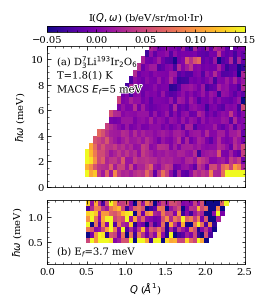

In [22]:
fig=plt.figure(constrained_layout=True,figsize=(3.54,4))

gs = matplotlib.gridspec.GridSpec(3,2,figure=fig)

#Perform masking of low-Q and elastic lines
ws_macs_masked= mask_QE_box_MD(mtd['macs_5mag'],[0,5],[0,1.0])
ws_macs_masked= mask_QE_box_MD(ws_macs_masked,[0,0.5],[0,20.0])
ws_macs_masked = CloneWorkspace(ws_macs_masked,OutputWorkspace='macs_5mag_plot')
#ws_macs_masked = SmoothMD(ws_macs_masked,'Hat',WidthVector=3)

ws_macs3_masked= mask_QE_box_MD(mtd['macs_3p7mag'],[0,5],[0,0.3])
ws_macs3_masked= mask_QE_box_MD(ws_macs3_masked,[0,0.5],[0,2.0])
ws_macs3_masked= mask_QE_box_MD(ws_macs3_masked,[0,2.5],[0,0.5])

ws_macs3_masked = CloneWorkspace(ws_macs3_masked,OutputWorkspace='macs_3p7mag_plot')
ws_macs3_masked = SmoothMD(ws_macs3_masked,'Hat',WidthVector=1)
ax_5 = fig.add_subplot(gs[0:2,:],projection='mantid')
ax_5.pcolormesh(ws_macs_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax_5.set_xlabel('')
ax_5.set_xticklabels([])
ax_5.set_ylabel('$\hbar\omega$ (meV)')
ax_5.set_ylim(0,11)
labela = ax_5.text(0.05,0.95,'(a) D$_3^7$Li$^{193}$Ir$_2$O$_6$\nT=1.8(1) K\nMACS $E_f$=5 meV',transform=ax_5.transAxes,verticalalignment='top',horizontalalignment='left')
labela.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar
l,b,w,h=ax_5.get_position().bounds
cax = fig.add_axes([l,b+h+0.05,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

ax_3 = fig.add_subplot(gs[2,:],projection='mantid')
ax_3.pcolormesh(ws_macs3_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax_3.set_xlabel('$Q$ ($\AA^{1}$)')
ax_3.set_ylabel('$\hbar\omega$ (meV)')
txt3=ax_3.text(0.05,0.08,'(b) E$_f$=3.7 meV',transform=ax_3.transAxes,verticalalignment='bottom',horizontalalignment='left')
txt3.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Make consistent Q dimensions between the different Ef's
qlim=[0,2.5]
ax_5.set_xlim(qlim[0],qlim[1])
ax_3.set_xlim(qlim[0],qlim[1])


fig.savefig('DLIO_MACS_scattering.pdf',bbox_inches='tight',dpi=300)

## Factorization of MACS data here

In [23]:
macs5_factor_fname='MACS5_fact.npy'
macs5factor=MDfactorization(mtd['macs_5mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,2],e_lim=[1.0,10],Ei=13.7,\
                                     twoThetaMin=False,plot_result=False,method='powell',fname=macs5_factor_fname,\
                                     overwrite_prev=False,allow_neg_E=False,g_factor=2.0,fast_mode=False)
macs3_factor_fname='MACS3p7_fact.npy'
macs3factor=MDfactorization(mtd['macs_3p7mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,1.9],e_lim=[0.5,1.3],Ei=5.0,\
                                     twoThetaMin=False,plot_result=False,method='powell',fname=macs3_factor_fname,\
                                     overwrite_prev=False,allow_neg_E=False,g_factor=2.0,fast_mode=False)



Moment = 1.732 (0.130)


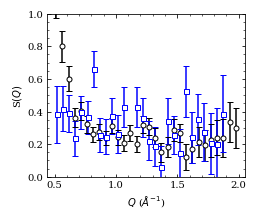

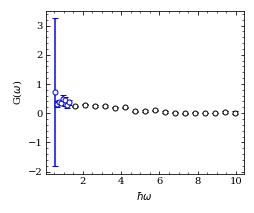

Moment = 1.732 (0.130)


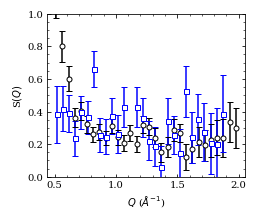

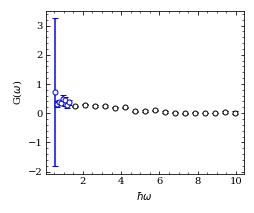

In [24]:
#Quick plots checking the factorizations, recalling that the spectral weight integrates to one
scale3=0.3

fig,ax=plt.subplots(1,1,figsize=(3.54,3))
ax.errorbar(macs5factor[0],macs5factor[1],macs5factor[2],color='k',marker='o',ls=' ',capsize=3)
ax.errorbar(macs3factor[0],macs3factor[1]/scale3,macs3factor[2]/scale3,color='b',marker='s',ls=' ',capsize=3)
ax.set_xlabel('$Q$ ($\AA^{-1}$)')
ax.set_ylabel('S$(Q)$')
ax.set_ylim(0,1)

fig,ax=plt.subplots(1,1,figsize=(3.54,3))
ax.errorbar(macs5factor[3],macs5factor[4],macs5factor[5],color='k',marker='o',ls=' ',capsize=3)
ax.errorbar(macs3factor[3],macs3factor[4]*scale3,macs3factor[5]*scale3,color='b',marker='o',ls=' ',capsize=3)
ax.set_ylabel('G($\omega$)')
ax.set_xlabel('$\hbar\omega$')

#Overall moment suggested by this factorization:
norm_err = 0.3# as a percent error
frac_err = norm_err#*macs5factor[1]/macs5factor[2]
momentsqr = 3.0*(2.0**2)*np.trapz(macs5factor[1]*macs5factor[0]**2,x=macs5factor[0])/\
            np.trapz(macs5factor[0]**2,x=macs5factor[0])
moment = np.sqrt(momentsqr)

errnum = get_trapz_err(macs5factor[0],macs5factor[1]*macs5factor[0]**2,\
                       macs5factor[1]*np.sqrt((macs5factor[2]/macs5factor[1])**2+frac_err**2)\
                       *macs5factor[0]**2)
momentsqr_err = 3.0*(2.0**2) * errnum/np.trapz(macs5factor[0]**2,x=macs5factor[0])
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment = {moment:.3f} ({moment_err:.3f})")

## Plot of HYS measurements here

Int G(omega)=0.9249550026534998


constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


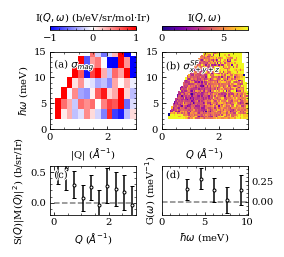

In [41]:
fig=plt.figure(constrained_layout=True,figsize=(3.54,3.0))

gs = matplotlib.gridspec.GridSpec(12,2,figure=fig,hspace=1.5,wspace=0.3)

ax_mag_sqe = fig.add_subplot(gs[0:6,0],projection='mantid')
ax_sf_sqe = fig.add_subplot(gs[0:6,1],projection='mantid')

ax_sq = fig.add_subplot(gs[8:,0])
ax_ge = fig.add_subplot(gs[8:,1])

#Add low energy masking
ws_hys_masked= mask_QE_box_MD(mtd['hys_mag'],[0,5],[0,2])
ws_hys_masked = CloneWorkspace(ws_hys_masked,OutputWorkspace='hys_mag_plot')
ws_hys_maskedSF= mask_QE_box_MD(mtd['hys_SF'],[0,5],[0,2])
ws_hys_maskedSF = CloneWorkspace(ws_hys_maskedSF,OutputWorkspace='hys_SF_plot')

mesh_mag = ax_mag_sqe.pcolormesh(mtd['hys_mag_plot'],vmin=-1,vmax=1,cmap='bwr',rasterized=True)
ax_mag_sqe.set_xlim(0,3)
ax_mag_sqe.set_ylim(0,15)
txta=ax_sf_sqe.text(0.05,0.92,'(a) $\sigma_{mag}$',transform=ax_mag_sqe.transAxes,horizontalalignment='left',verticalalignment='top')
txta.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])
#Add a colorbar to magnetic 
l,b,w,h=ax_mag_sqe.get_position().bounds
cax = fig.add_axes([l,b+h+0.1,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh_mag,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

ax_mag_sqe.set_ylabel('$\hbar\omega$ (meV)')

mesh_sf = ax_sf_sqe.pcolormesh(mtd['hys_SF_plot'],vmin=0,vmax=7,cmap=cmap,rasterized=True)
ax_sf_sqe.set_ylabel('')
ax_sf_sqe.set_xlim(0,3)
ax_sf_sqe.set_ylim(0,15)
txtb=ax_sf_sqe.text(0.05,0.92,'(b) $\sigma_{x+y+z}^{SF}$',transform=ax_sf_sqe.transAxes,horizontalalignment='left',verticalalignment='top')
txtb.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar for SF
l,b,w,h=ax_sf_sqe.get_position().bounds
cax = fig.add_axes([l,b+h+0.1,w,0.02])
labelstr='I($Q,\omega$)'
cbar = plt.colorbar(mesh_sf,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))


#Cuts in Q, energy, are done on the analysis cluster - event files too large for personal machine. 
# Scripts for cluster available upon request.
qcutmag = np.genfromtxt('../Part 5 - HYS Scattering/cut_data/sq_mag_cut_.txt',skip_header=2)
ecutmag = np.genfromtxt('../Part 5 - HYS Scattering/cut_data/ge_mag_cut.txt',skip_header=2)
# These cuts were normalized on the analysis cluster with a factor of 1.2e5- undone by this factor.
rescale_factor = 1.5e5 / 1.2e5
qcutmag[:,0],qcutmag[:,1]=qcutmag[:,0]*rescale_factor ,qcutmag[:,1]*rescale_factor
ecutmag[:,0],ecutmag[:,1]=ecutmag[:,0]*rescale_factor ,ecutmag[:,1]*rescale_factor


r0=0.5391
g=2.0
xtos = (r0**2 * g**2)/2.0
#For some reason MANTID 
ax_sq.errorbar(qcutmag[:,2],qcutmag[:,0]/xtos,qcutmag[:,1]/xtos,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2,ms=3)

ax_ge.errorbar(ecutmag[:,2],ecutmag[:,0],ecutmag[:,1],color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2,ms=3)
ax_ge.set_xlim(0,10)
ax_sq.set_ylim(-0.2,0.6)
ax_sq.plot(np.linspace(0,np.nanmax(qcutmag[:,2]),1000),np.zeros(1000),'k--',alpha=0.5)
ax_ge.plot(np.linspace(0,10,1000),np.zeros(1000),'k--',alpha=0.5)
ax_ge.yaxis.tick_right()

ax_sq.set_xlabel('$Q$ ($\AA^{-1}$)')
ax_sf_sqe.set_xlabel('$Q$ ($\AA^{-1}$)')

ax_ge.set_xlabel('$\hbar\omega$ (meV)')

ax_sq.set_ylabel('S($Q$)|M($Q$)|$^2$) (b/sr/Ir)')
ax_ge.set_ylabel('G($\omega$) (meV$^{-1}$)')


txtc=ax_sq.text(0.05,0.9,'(c)',transform=ax_sq.transAxes,horizontalalignment='left',verticalalignment='top')
txtc.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

txtd=ax_ge.text(0.05,0.9,'(d)',transform=ax_ge.transAxes,horizontalalignment='left',verticalalignment='top')
txtd.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

integral = np.trapz(ecutmag[:,0],x=ecutmag[:,2])
print(f"Int G(omega)={integral}")

fig.savefig('HYS_scattering.pdf',bbox_inches='tight',dpi=300)

## HYS factorizations, or attempts. 

This is extremely touchy due to poor statistics.

In [42]:
hys_mag_factorname='hys_magfactor.npy'

md_factor = mtd['hys_mag']
factor_hysmag = MDfactorization(md_factor,mag_ion='Ir4', q_lim=[0.2,2.0],e_lim=[2.0,10.0],Ei=20.0,
                                     twoThetaMin=False,plot_result=True,method='powell',fname=hys_mag_factorname,
                                     overwrite_prev=True,g_factor=2.0,fast_mode=True,allow_neg_E=False)

#Instead it is easier to just use the cuts with the appropriate normalizations. Fitting routine is not stable.
factor_hysmag_alt = [qcutmag[:,2]*integral,qcutmag[:,0]*integral,qcutmag[:,1]*integral,\
                     ecutmag[:,2]/integral,ecutmag[:,0]/integral,ecutmag[:,1]/integral]
#Mask highQ vals

<ErrorbarContainer object of 3 artists>

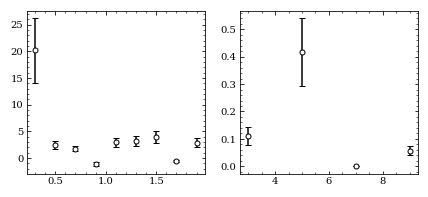

In [43]:
#For transparency, show the factorization as well.
fig, ax = plt.subplots(1,2,figsize=(7,3))
ax[0].errorbar(factor_hysmag[0],factor_hysmag[1],factor_hysmag[2],color='k')
ax[1].errorbar(factor_hysmag[3],factor_hysmag[4],factor_hysmag[5],color='k')
#ax[0].set_ylim(-0.1,0.5)
#ax[1].set_ylim(0,1)

Moment from cut= 1.649 (0.595)
Moment from factorization= 4.818 (nan)


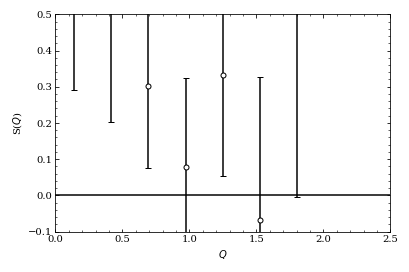

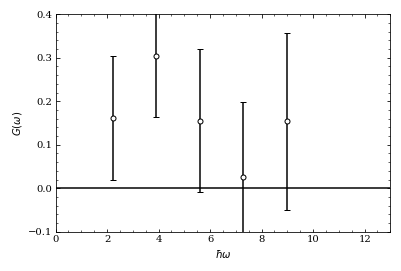

In [44]:
plt.figure()
#plt.errorbar(factor_hysmag[0],factor_hysmag[1],factor_hysmag[2])
qff,ff = get_MANTID_magFF(factor_hysmag_alt[0],mag_ion='Ir4')
magffsqr=1.0/ff
r0=0.5391
g=2.0
sq_alt = factor_hysmag_alt[1]*2.0/(r0**2 * (g)**2 * magffsqr)
sq_alt_err = factor_hysmag_alt[2]*2.0/(r0**2 * (g)**2 * magffsqr)
#Mask high Q values
maxQ = 2.0
sq_alt=sq_alt[np.where(factor_hysmag_alt[0]<maxQ)[0]]
sq_alt_err=sq_alt_err[np.where(factor_hysmag_alt[0]<maxQ)[0]]
q_alt = factor_hysmag_alt[0][np.where(factor_hysmag_alt[0]<maxQ)[0]]

plt.errorbar(q_alt,sq_alt,sq_alt_err,marker='o',ls=' ',color='k')

plt.plot(np.linspace(0,3,1000),np.zeros(1000),'k-')
plt.ylim(-0.1,0.5)
plt.xlim(0,2.5)
plt.xlabel('$Q$')
plt.ylabel('S($Q$)')
plt.figure()
#plt.errorbar(factor_hysmag[3],factor_hysmag[4],factor_hysmag[5])
plt.errorbar(factor_hysmag_alt[3]-1,factor_hysmag_alt[4],factor_hysmag_alt[5],marker='o',ls=' ',color='k')
plt.plot(np.linspace(0,15,1000),np.zeros(1000),'k-')
plt.xlim(0,13)
plt.ylim(-0.1,0.4)
plt.xlabel('$\hbar\omega$')
plt.ylabel('$G(\omega)$')

#Overall moment suggested by this factorization:
norm_err = 0.3
frac_err = norm_err#*factor_hysmag_alt[2]/factor_hysmag_alt[1]
moment_frac = 1.0
momentsqr = 3.0*(g**2)*np.trapz(moment_frac*sq_alt*q_alt**2,x=q_alt)/\
            np.trapz(q_alt**2,x=q_alt)
moment = np.sqrt(momentsqr)
errnum = get_trapz_err(q_alt,sq_alt*q_alt**2,\
                       sq_alt*np.sqrt((sq_alt/sq_alt_err)**2 + frac_err**2)*q_alt**2)
momentsqr_err = 3.0*(g**2) * errnum/np.trapz(q_alt**2,x=q_alt)
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment from cut= {moment:.3f} ({moment_err:.3f})")
momentsqr = 3.0*(g**2)*np.trapz(moment_frac*factor_hysmag[1]*factor_hysmag[0]**2,x=factor_hysmag[0])/\
            np.trapz(factor_hysmag[0]**2,x=factor_hysmag[0])
moment = np.sqrt(momentsqr)
errnum = get_trapz_err(factor_hysmag[0],factor_hysmag[1]*factor_hysmag[0]**2,\
                       factor_hysmag[1]*np.sqrt((factor_hysmag[1]/factor_hysmag[2])**2 + frac_err**2)*factor_hysmag[0]**2)
momentsqr_err = 3.0*(g**2) * errnum/np.trapz(factor_hysmag[0]**2,x=factor_hysmag[0])
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment from factorization= {moment:.3f} ({moment_err:.3f})")


## Finally, figure with factorizations + THz

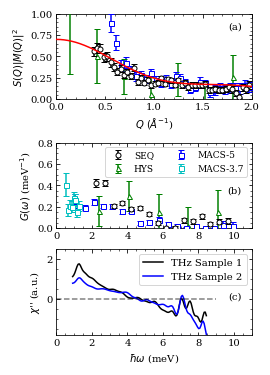

In [54]:
#THz imports 
thz_dir = "THz/"
thz_trans_main = np.genfromtxt(thz_dir+'Final_transmission_main_pellet.txt',skip_header=1)
temps_thz_trans_main = np.array([3.0,5.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,25.0,30.0,\
                                 40.0,50.0,70.0,100.0,125.0,300.0])
thz_trans2_main = np.genfromtxt(thz_dir+'Final_transmission_main_pellet_2.txt',skip_header=1)
temps_thz_trans2_main = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,50.0,70.0,100.0,125.0,150.0,175.0,\
                                 200.0,225.0,250.0,275.0,296.0])
thz_chi2_1 = np.genfromtxt(thz_dir+'Magnetic-susceptibility.txt',skip_header=1)
temps_thz_chi2_1 = np.array([14.0,12.0,10.0,10.0,8.0,5.0,3.0,14.0,12.0,10.0,10.0,8.0,5.0,3.0]) #Chi2 then chi2
thz_chi2_2 = np.genfromtxt(thz_dir+'Magnetic-susceptibility_2_ref25K.txt',skip_header=1)
temps_thz_chi2_2 = np.array([3.0,10.0,15.0,20.0,25.0,3.0,10.0,15.0,20.0,25.0]) #Chi1 then Chi2
thz_T_tempcut = np.genfromtxt(thz_dir +'transmission-temp-cuts_1.txt',skip_header=1)
freqs_thz_Ttempcut = np.array([0.41,0.45,0.50,0.55,0.60,0.70,0.75,0.80,0.85,0.90,\
                               0.41,0.45,0.50,0.55,0.60,0.70,0.75,0.80,0.85,0.90]) #Transmission frequency, then error
thz_T2_tempcut = np.genfromtxt(thz_dir +'transmission-temp-cuts_2.txt',skip_header=1)
freqs_thz_T2tempcut = np.array([0.35,0.41,0.45,0.55,0.60,0.70,0.75,0.80,0.85,0.90,\
                               0.35,0.41,0.45,0.55,0.60,0.70,0.75,0.80,0.85,0.90])
thz_T3_tempcut = np.genfromtxt(thz_dir+'transmission-temp-cuts_1_more_temp.txt',skip_header=1)
freqs_thz_T3tempcut = np.array([0.43,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85])

#First plot the THz spectra in the upper figure
THz_to_meV = 4.18
THz_3K_sample1 = thz_chi2_1[:,6]*1e3
THz_3K_E_sample1 = thz_chi2_1[:,0]*THz_to_meV
THz_3K_sample2 = thz_chi2_1[:,3]*1e3
THz_3K_E_sample2 = thz_chi2_1[:,0]*THz_to_meV

fig=plt.figure(constrained_layout=True,figsize=(3.54,5.0))

gs = matplotlib.gridspec.GridSpec(3,1,figure=fig,hspace=1.0,wspace=0.3)

sq_ax = fig.add_subplot(gs[0])
gw_ax = fig.add_subplot(gs[1])
thz_ax = fig.add_subplot(gs[2])

#Start with S(Q) factorizations, fit to model
# We want to plot the more closely observed quantity |F(Q)|^2 * S(Q)
# SEQ, MACS, HYS
seq_scale = 1.0
sq_ax.text(0.95,0.9,'(a)',transform=sq_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')
markersize=5
macs3scale=1.0/0.17
macs5scale=1.0/0.83 #These factors are to estimate what fraction of spectral weight is carried
# by each Ef setting in the MACS measurements.
hys_scale = 1.0
ffseq = 1.0/get_MANTID_magFF(qseq,'Ir4')[1]
sq_ax.errorbar(qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale,color='k',\
               marker='o',mfc='w',mec='k',ls=' ',capsize=3,zorder=10,ms=markersize)
ffmacs = 1.0/get_MANTID_magFF(macs5factor[0],'Ir4')[1]
ffmacs3 = 1.0/get_MANTID_magFF(macs3factor[0],'Ir4')[1]

sq_ax.errorbar(macs5factor[0],macs5factor[1]*ffmacs*macs5scale,macs5factor[2]*ffmacs*macs5scale,color='b',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)

#sq_ax.errorbar(macs3factor[0],macs3factor[1]*ffmacs3*macs3scale,macs3factor[2]*ffmacs3*macs3scale,color='c',marker='s',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)
ffhys = 1.0/get_MANTID_magFF(q_alt,'Ir4')[1]
sq_ax.errorbar(q_alt,sq_alt*ffhys*hys_scale,sq_alt_err*ffhys*hys_scale,color='g',\
               marker='^',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)
def modelq(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))
qmodel = np.linspace(0,2.5,1000)
ffmodel=1.0/get_MANTID_magFF(qmodel,'Ir4')[1]
sq_ax.plot(qmodel,modelq(qmodel,0.35)*seq_scale*ffmodel,'r-',zorder=100)
#Now G(omega)

#Strange error bars on the lowest energy seq and MACS 3.7 meV data.
geerrseq[0] = np.nanmean(geerrseq[1:])*2.0
macs3factor[5][0] = np.nanmean(macs3factor[5][1:])*2.0
gw_ax.errorbar(eseq,geseq/seq_scale,geerrseq/seq_scale,color='k',marker='o',mfc='w',mec='k',ls=' ',\
               capsize=3,zorder=10,label='SEQ',ms=markersize)
hys_ge_res = np.abs(factor_hysmag_alt[3][1]-factor_hysmag_alt[3][0])
gw_ax.errorbar(factor_hysmag_alt[3]-hys_ge_res/2,factor_hysmag_alt[4]/hys_scale,factor_hysmag_alt[5]/hys_scale,color='g',\
               marker='^',ls=' ',capsize=3,zorder=5,mfc='w',label='HYS',ms=markersize)
gw_ax.errorbar(macs5factor[3],macs5factor[4]/macs5scale,macs5factor[5]/macs5scale,color='b',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',label='MACS-5',ms=markersize)
gw_ax.errorbar(macs3factor[3],macs3factor[4]/macs3scale,macs3factor[5]/macs3scale,color='c',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',label='MACS-3.7',ms=markersize)

gw_ax.text(0.95,0.5,'(b)',transform=gw_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')
gw_ax.legend(fontsize=9,loc=1,ncol=2)
gw_ax.set_ylim(0,0.8)

sq_ax.set_ylim(0,1)
sq_ax.set_xlim(0,2.0)


thz_ax.plot(THz_3K_E_sample1,THz_3K_sample1,'k-',label='THz Sample 1')
thz_ax.plot(THz_3K_E_sample2,THz_3K_sample2,'b-',label='THz Sample 2')
thz_ax.plot(np.linspace(0,9,1000),np.zeros(1000),'k--',alpha=0.5)
thz_ax.set_ylabel('$\chi$\'\' (a.u.)')
thz_ax.text(0.95,0.5,'(c)',transform=thz_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')

#Have the G(w) and THz subplots share an x-axis 
thz_ax.sharex(gw_ax)
thz_ax.set_ylim(-1.8,2.5)
thz_ax.set_xlim(0,11)
thz_ax.legend()

#Axis labels
sq_ax.set_ylabel('$S(Q)|M(Q)|^2$')
sq_ax.set_xlabel(r'$Q$ $(\AA^{-1}$)')

gw_ax.set_ylabel('$G(\omega)$ (meV$^{-1}$)');
thz_ax.set_xlabel('$\hbar\omega$ (meV)')

fig.savefig('HLIO_factorizations_THz.pdf',bbox_inches='tight')

In [30]:
macs3factor[5]

array([0.61916956, 0.32482262, 0.30862236, 0.29680268, 0.35700842,
       0.30855576, 0.30586545, 0.26541618])

array([0.61916956, 0.32482262, 0.30862236, 0.29680268, 0.35700842,
       0.30855576, 0.30586545, 0.26541618])

Integrated g(w)=1.00


(-0.05, 0.5)

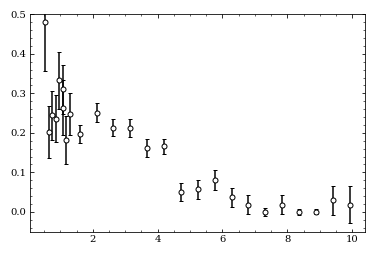

Integrated g(w)=1.00


(-0.05, 0.5)

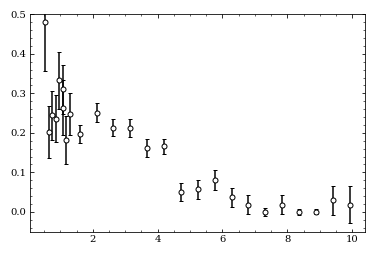

In [31]:
# The MACS data is assumed to cover the full spectral range, thus its G(omega) should integrate to one. 
frac3 = 0.2
frac5 = 0.85
e_all_macs = np.append(macs3factor[3],macs5factor[3])
ge_all_macs = np.append(macs3factor[4]*frac3,frac5*macs5factor[4])
geerr_all_macs = np.append(macs3factor[5]*frac3,macs5factor[5]*frac5)
#Sort these
sorti = np.argsort(e_all_macs)
e_all_macs, ge_all_macs, geerr_all_macs = e_all_macs[sorti], ge_all_macs[sorti], geerr_all_macs[sorti]

integral = np.trapz(ge_all_macs,x=e_all_macs)
print(f"Integrated g(w)={integral:.2f}")
fig,ax = plt.subplots(1,1)
ax.errorbar(e_all_macs,ge_all_macs,geerr_all_macs,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2)
ax.set_ylim(-0.05,0.5)

[[Model]]
    Model(knolle_qmodel)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 224
    # data points      = 47
    # variables        = 2
    chi-square         = 202.205769
    reduced chi-square = 4.49346154
    Akaike info crit   = 72.5794971
    Bayesian info crit = 76.2797924
[[Variables]]
    A:  0.30320785 (init = 0.3)
    K: -0.01552797 (init = -10)



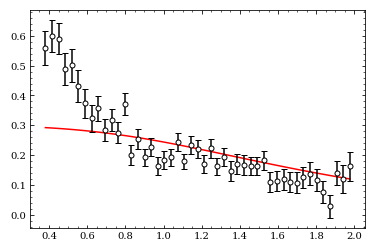

[[Model]]
    Model(knolle_qmodel)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 224
    # data points      = 47
    # variables        = 2
    chi-square         = 202.205769
    reduced chi-square = 4.49346154
    Akaike info crit   = 72.5794971
    Bayesian info crit = 76.2797924
[[Variables]]
    A:  0.30320785 (init = 0.3)
    K: -0.01552797 (init = -10)



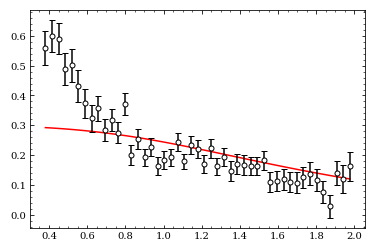

In [32]:
## Fit to find the rough value of $K$
#qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale

def knolle_qmodel(q,A,K):
    return A*(1+K*np.cos(q*3.54))

modelK = Model(knolle_qmodel)
paramsK = modelK.make_params()
paramsK.add('A',value=0.3,min=0.0,max=100.0)
paramsK.add('K',value=-10,min=-200,max=200)
resultK = modelK.fit(sqseq,q=qseq,weights=1.0/sqerrseq,params=paramsK,method='powell')
fig,ax = plt.subplots(1,1)
ax.errorbar(qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale,color='k',\
               marker='o',mfc='w',mec='k',ls=' ',capsize=3,zorder=10,ms=markersize)
ax.plot(qseq,resultK.best_fit*ffseq*seq_scale,'r-')
print(resultK.fit_report())